In [1]:
#look at molecules from the smaller sets from shuzhe, can they be used as external test set?
import pandas as pd
fragrance_DB = pd.read_csv('/localhome/cschiebroek/ShuZe/vp/data cleaning/cleaned_vp_fragrancedb.tsv', sep='\t')
lts = pd.read_csv('/localhome/cschiebroek/ShuZe/vp/data cleaning/cleaned_vp_lts.tsv', sep='\t')
good_scent_company = pd.read_csv('/localhome/cschiebroek/ShuZe/vp/data cleaning/cleaned_vp_website.tsv', sep='\t')
#combine. they all have the same columns, expect for the last one
all_molecules = pd.concat([fragrance_DB, lts, good_scent_company])
#has now columns FRAGRANCE VP	LTS VP	WEBSITE VP, with value either True or NaN. make this into one column, called 'source', which is either 'fragrance', 'lts' or 'website'
all_molecules['source'] = all_molecules.apply(lambda row: 'fragrance' if row['FRAGRANCE VP'] else ('lts' if row['LTS VP'] else ('website' if row['WEBSITE VP'] else 'unknown')), axis=1)
#remove the original columns
all_molecules = all_molecules.drop(columns=['FRAGRANCE VP', 'LTS VP', 'WEBSITE VP'])
#remove duplicates 
all_molecules_298 = all_molecules[all_molecules['Temperature'] == 298.15]
print(len(all_molecules_298['SMILES'].unique()))
#about 192 unique molecules, not bad. 


198


In [2]:
from rdkit import Chem
mols_combined = [Chem.MolFromSmiles(smi) for smi in all_molecules_298['SMILES'].unique()]

In [3]:
#now check how many of these are already in the training set. first normalize, then query
from rdkit.Chem.MolStandardize import rdMolStandardize
mols_combined_standardized = [rdMolStandardize.ChargeParent(mol) for mol in mols_combined]


[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Running LargestFragmentChooser
[13:23:31] Fragment: O=C(OCc1ccccc1)c1ccccc1
[13:23:31] New largest fragment: O=C(OCc1ccccc1)c1ccccc1 (28)
[13:23:31] Running Uncharger
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Running LargestFragmentChooser
[13:23:31] Fragment: C1CCSC1
[13:23:31] New largest fragment: C1CCSC1 (13)
[13:23:31] Running Uncharger
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializi

In [4]:
#add the standardized SMILES to the dataframe
all_molecules_298['SMILES_standardized'] = all_molecules_298['SMILES'].apply(lambda smi: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles(smi))))

[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Running LargestFragmentChooser
[13:23:31] Fragment: O=C(OCc1ccccc1)c1ccccc1
[13:23:31] New largest fragment: O=C(OCc1ccccc1)c1ccccc1 (28)
[13:23:31] Running Uncharger
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Running LargestFragmentChooser
[13:23:31] Fragment: C1CCSC1
[13:23:31] New largest fragment: C1CCSC1 (13)
[13:23:31] Running Uncharger
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializing Normalizer
[13:23:31] Running Normalizer
[13:23:31] Initializing MetalDisconnector
[13:23:31] Running MetalDisconnector
[13:23:31] Initializi

In [5]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils
#using our standard settings for our databse cs_mdfps
config = lwreg.utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'scotland'
config['user'] = 'cschiebroek'
config['password'] = '' 
config['standardization'] = standardization_lib.RemoveHs()
config['registerConformers'] = True

In [6]:
#query all the molecules
molregnos_to_add = []
for mol in all_molecules_298['SMILES_standardized']:
    query = lwreg.query(config = config, smiles=mol)
    if len(query) == 0:
        molregnos_to_add.extend([None])
    else:
        molregnos_to_add.extend(query)
all_molecules_298['molregno'] = molregnos_to_add

/tmp/ipykernel_3154940/2715206366.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_molecules_298['molregno'] = molregnos_to_add


In [7]:
all_molecules_298
#add column vp_log10_pa, gotten from Vapour Pressure (log10 kPa)
#first Vapour Pressure (kPa) from Vapour Pressure (log10 kPa)
all_molecules_298['vp_kPa'] = 10**all_molecules_298['Vapour Pressure (log10 kPa)']
#then kpa to pa
all_molecules_298['vp_pa'] = all_molecules_298['vp_kPa']*1000
#then log10
import math
all_molecules_298['vp_log10_pa'] = all_molecules_298['vp_pa'].apply(lambda x: math.log10(x))

/tmp/ipykernel_3154940/815339910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_molecules_298['vp_kPa'] = 10**all_molecules_298['Vapour Pressure (log10 kPa)']
/tmp/ipykernel_3154940/815339910.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_molecules_298['vp_pa'] = all_molecules_298['vp_kPa']*1000
/tmp/ipykernel_3154940/815339910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [8]:
all_molecules_298

,hash_code,SMILES,Temperature,Vapour Pressure (log10 kPa),source,SMILES_standardized,molregno,vp_kPa,vp_pa,vp_log10_pa
0,01700605f281e9c94a74c1f9fce89f20,[O]=[C](-[O]-[CH2]-[c]1:[cH]:[cH]:[cH]:[cH]:[c...,298.15,-4.524850,fragrance,O=C(OCc1ccccc1)c1ccccc1,21.0,0.000030,0.029864,-1.524850
2,04efd594a6c81968f4fd8eb05fd69f7f,[CH2]1-[CH2]-[CH2]-[S]-[CH2]-1,298.15,0.380211,fragrance,C1CCSC1,16772.0,2.400000,2399.999983,3.380211
3,0539b760ea727471e54711c4ac3b2c88,[CH3]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2...,298.15,-3.701912,fragrance,CCCCCCCCCCCCCCCC,17133.0,0.000199,0.198650,-0.701912
5,08ab7a61e896dc23ab0a78554241f8ea,[CH3]-[CH2]-[CH2]-[CH2]-[OH],298.15,-0.030000,fragrance,CCCCO,16864.0,0.933254,933.254000,2.970000
7,0adc8a633eb3d414424603ba6965b6af,[CH3]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2]-[CH2...,298.15,-4.833705,fragrance,CCCCCCCCCCCCCCO,125.0,0.000015,0.014665,-1.833705
...,...,...,...,...,...,...,...,...,...,...
179,f6184df0e14450c66c298e5cb45c428b,[CH3]-[c]1:[cH]:[cH]:[c](-[OH]):[cH]:[c]:1-[CH3],298.15,-2.323648,fragrance,Cc1ccc(O)cc1C,4110.0,0.004746,4.746263,0.676352
181,f720fcda3f9edbf0eb0eb7eacc4066c3,[CH3]-[C](=[O])-[CH]=[C](-[CH3])-[CH3],298.15,0.039245,fragrance,CC(=O)C=C(C)C,4124.0,1.094574,1094.573620,3.039245
183,fa6e16dee9513a716bf17a0bb4d86c63,[CH3]-[c]1:[cH]:[cH]:[c](-[C](-[CH3])(-[CH3])-...,298.15,-1.062185,fragrance,Cc1ccc(C(C)(C)C)cc1,4161.0,0.086659,86.659300,1.937815
185,fc34e3e10d5791a95a9a0e9d7d1f6c2a,[CH3]-[C](-[CH3])(-[CH3])-[OH],298.15,0.741324,fragrance,CC(C)(C)O,4186.0,5.512184,5512.183539,3.741324


In [9]:
import psycopg2
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=scotland")
cur = conn.cursor()

In [10]:
#for molregno in molregnos_already_registered, check if there is an entry in cs_mdfps_schema.experimental_data

query = "SELECT * FROM cs_mdfps_schema.experimental_data WHERE molregno = ANY(%s)"
cur.execute(query, (all_molecules_298['molregno'].tolist(),))
rows = cur.fetchall()
print(len(rows))
#get these datapoints
datapoints = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])
print(datapoints.head())

158
   molregno  vp_log10_pa      source metadata
0       205     2.707000  Naef_Acree       {}
1       842     3.666000  Naef_Acree       {}
2      3749     1.036000  Naef_Acree       {}
3      3252     2.556000  Naef_Acree       {}
4      3172     0.665201       OPERA       {}


101 101


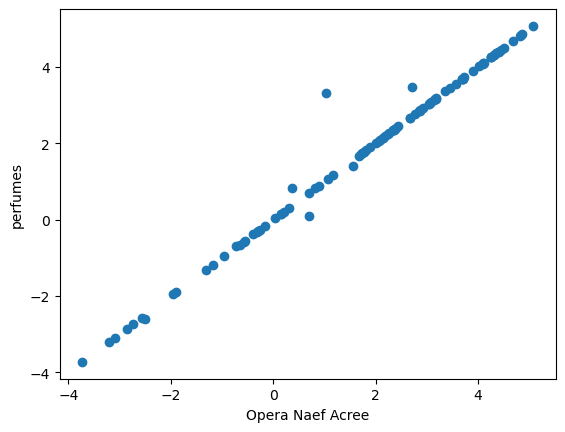

In [11]:
#for all molregnos, get val from datapoints and from all_molecules_298. plot against each other
import numpy as np
vp_vals_opera_naef_acree, vp_vals_perfumes = [],[]
for mrno in all_molecules_298['molregno']:
    if mrno is None:
        continue
    else:
        vp_vals_opera_naef_acree_all = datapoints[datapoints['molregno'] == mrno]['vp_log10_pa'].tolist()
        if len(vp_vals_opera_naef_acree_all) < 1:
            continue
        vp_vals_perfumes_all = all_molecules_298[all_molecules_298['molregno'] == mrno]['vp_log10_pa'].tolist()
        if len(vp_vals_perfumes_all) > 1:
            continue
            vp_vals_perfumes.append(np.mean(vp_vals_perfumes_all))
        else:
            vp_vals_perfumes.extend(vp_vals_perfumes_all)

        vp_vals_opera_naef_acree.extend(datapoints[datapoints['molregno'] == mrno]['vp_log10_pa'].tolist())
#print lens
print(len(vp_vals_opera_naef_acree), len(vp_vals_perfumes))
#plt    
import matplotlib.pyplot as plt
plt.scatter(vp_vals_opera_naef_acree, vp_vals_perfumes)
plt.xlabel('Opera Naef Acree')
plt.ylabel('perfumes')
plt.show()
#okay so pretty much all the same



In [16]:
molregnos = all_molecules_298['molregno'].tolist()
molregnos = [mrno for mrno in molregnos if mrno is not None]
molregnos = list(set(molregnos))
print(len(molregnos))


217


In [19]:
df_feats = pd.read_csv('data_curation/mols_mdfp_physchem_features.csv')
df_feats

,molregno,conf_id,vp_log10_pa,mdfp,molblock,ROMol,descriptors,mdfp_vec,NumHeavyAtoms,NumN,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,NumRotatableBonds
0,8,1151,-3.053298,"{'mdfp': '[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97....",[H]OC(=O)c1c([H])c([H])c2c([H])c([H])c([H])c([...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61fef300>,"{'MaxAbsEStateIndex': 10.644614040060468, 'Max...","[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",13.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,9,1152,3.593202,"{'mdfp': '[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.484...",[H]C([H])(Cl)OC([H])([H])Cl\n RDKit ...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61fef370>,"{'MaxAbsEStateIndex': 4.994984567901234, 'MaxE...","[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.4848459757350...",5.0,0.0,...,0,0,0,0,0,0,0,0,0,2
2,11,1154,5.259101,"{'mdfp': '[4, 0, 0, 0, 1, 0, 0, 2, 0, 0, -0.10...",[H]C(F)(Cl)Cl\n RDKit 3D\n\n 0 ...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61fef290>,"{'MaxAbsEStateIndex': 10.530864197530864, 'Max...","[4, 0, 0, 0, 1, 0, 0, 2, 0, 0, -0.104781552046...",4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,12,1155,-3.104198,"{'mdfp': '[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -105...",[H]OC(=O)C([H])([H])Oc1c([H])c([H])c(Cl)c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61fef220>,"{'MaxAbsEStateIndex': 10.199797003163404, 'Max...","[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -105.003804343...",13.0,0.0,...,0,0,0,0,0,0,0,0,0,3
4,13,1156,3.664201,"{'mdfp': '[6, 2, 0, 0, 0, 0, 0, 0, 1, 0, -1.41...",[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61fef1b0>,"{'MaxAbsEStateIndex': 3.349930555555556, 'MaxE...","[6, 2, 0, 0, 0, 0, 0, 0, 1, 0, -1.410024750661...",6.0,0.0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,3749,17247,1.036000,"{'mdfp': '[11, 1, 0, 1, 0, 0, 0, 0, 0, 0, -22....",[H]C([H])=C(C([H])([H])[H])[C@]1([H])C([H])([H...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61e4f7d0>,"{'MaxAbsEStateIndex': 11.199537037037036, 'Max...","[11, 1, 0, 1, 0, 0, 0, 0, 0, 0, -22.7079118557...",11.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3227,2545,17253,2.301000,"{'mdfp': '[4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5.357...",[H]/C(I)=C(\[H])I\n RDKit 3D\n\n ...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61e4f840>,"{'MaxAbsEStateIndex': 2.1633333333333336, 'Max...","[4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5.3572325631171...",4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3228,3394,17254,2.296000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.0...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61e4f8b0>,"{'MaxAbsEStateIndex': 9.177685185185185, 'MaxE...","[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.02947008199...",8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3229,2680,17260,2.216000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.1...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x7f0d61e4f920>,"{'MaxAbsEStateIndex': 9.177685185185185, 'MaxE...","[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -24.16582824638...",8.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
from rdkit.Chem import rdFingerprintGenerator

def get_fps(ms, generator=None):
    " generate fingerprints for a set of molecules "
    if generator is None:
        #generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=6)
        generator = rdFingerprintGenerator.GetMorganGenerator(radius=3)
    fps = [generator.GetFingerprint(x) for x in ms]
    return fps

In [27]:
df_feats['mol'] = [Chem.MolFromMolBlock(x) for x in df_feats['molblock']]
fps = get_fps(df_feats.mol)
df_feats['fps'] = fps

In [30]:
df_in_mrnos = df_feats[df_feats['molregno'].isin(molregnos)]
print(len(df_in_mrnos))
df_not_in_mrnos = df_feats[~df_feats['molregno'].isin(molregnos)]
print(len(df_not_in_mrnos))

157
3074


In [28]:
import bisect

import numpy as np
import pandas as pd
from rdkit import Chem
import pandas as pd
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import random
from sklearn.model_selection import train_test_split
def get_distance_cdf(fps1,
                     fps2,
                     removeSelf=False,
                     vals=np.arange(0, 1.01, 0.01)):
    ' finds the CDF for the closest member of fps2 to each element of fps1 '
    nbrds = []
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        nbrds.append(min(ds))
    nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)
    return res
def get_dissim_cdf(fps1,
                   fps2,
                   frac=0.2,
                   removeSelf=False,
                   vals=np.arange(0, 1.01, 0.01)):
    ' finds the CDF for the X percentile most-distant member of fps2 to each element of fps1 '
    nbrds = []
    refPos = int(frac * len(fps2))
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        ds = sorted(ds)
        nbrds.append(ds[refPos])
    nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)
    return res
def get_randomdist_cdf(fps1,
                       fps2,
                       distThresh=0.8,
                       removeSelf=False,
                       vals=np.arange(0, 1.01, 0.01)):
    ''' CDF of number of points in fps2 which are greater than distThresh 
      from each point in fps1 
    '''
    nbrds = []
    nfps2 = len(fps2)
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        ds = sorted(ds)
        pos = bisect.bisect_left(ds, distThresh)
        nbrds.append((nfps2 - pos) / nfps2)
        nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)
    return res

def get_relateddist_cdf(fps1,
                        fps2,
                        distThresh=0.65,
                        removeSelf=False,
                        vals=np.arange(0, 1.01, 0.01)):
    ''' CDF of number of points in fps2 which are less than distThresh 
      from each point in fps1 
    '''
    nbrds = []
    nfps2 = len(fps2)
    for i, fp in enumerate(fps1):
        ds = DataStructs.BulkTanimotoSimilarity(fp, fps2, returnDistance=1)
        if removeSelf:
            ds.pop(i)
        ds = sorted(ds)
        nbrds.append(bisect.bisect_left(ds, distThresh) / nfps2)
    nPts = len(nbrds)
    nbrds = np.array(nbrds)
    res = []
    for v in vals:
        res.append(np.sum(nbrds <= v) / nPts)

    return res

def modified_spatial_stats(testfps,
                           trainfps,
                           vals=np.arange(0, 1.01, 0.01)):
    ' calculates F using closest member of train to test instead of vice-versa '
    g_vals = get_distance_cdf(testfps, testfps, removeSelf=True, vals=vals)
    tfps = trainfps
    bootstrap = [
        tfps[x]
        for x in [random.randint(0,
                                 len(tfps) - 1) for x in range(len(tfps))]
    ]
    f_vals = get_distance_cdf(testfps, bootstrap, vals=vals)
    s_vals = [f - g for f, g in zip(f_vals, g_vals)]
    return vals, g_vals, f_vals, s_vals

In [32]:
vals_lao, g_vals_lao, f_vals_lao, s_vals_lao = modified_spatial_stats(df_in_mrnos['fps'].tolist(), df_not_in_mrnos['fps'].tolist())
#print sums
print(sum(g_vals_lao), sum(f_vals_lao), sum(s_vals_lao))

56.05095541401275 63.509554140127406 7.458598726114653
